# X/Twitter Sentiment Analysis 

##### This project aims to allow user to upload excel dataset path from their computer and through a open source pre-trained model, analyse the tweets and add additional columns about the sentiments behind those tweets

##### Importing necessary packages

In [27]:
import pandas as pd
from contractions import *
import re
import os
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tkinter import *
from tkinter.ttk import *
from tkinter import filedialog
from tkinter import messagebox 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

After importing the packages, we need to define a window, which will be the user interface. This window is currently set as "None" so that it can be accessed later on when it is withdrawn.

In [28]:
Window=None


We will also define a pre-requisite variable, "contractions", to expand the abbreviated english terms

In [29]:
contractions_dict = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
                    "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us", "mustn't": "must not", "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not", "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will", "they're": "they are", 
                    "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will","what're": "what are", "what's": "what is", "what've": "what have", "where's": "where is", "who'd": "who would", "who'll": "who will", "who're": "who are", "who's": "who is", "who've": "who have",
                    "won't": "will not", "would've": "would have", "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have"}       

### User-Defined Functions
We will define a "browse_file" function that will allow user to browse through the files using a button or they can just enter the path of the file they want to analyse

In [30]:
def browse_file():
    file_path = filedialog.askopenfilename(filetypes=[("Excel file", "*.xlsx")])
    file_path_entry.delete(0, 'end')
    file_path_entry.insert(0, file_path)     



Using "Decontracted" method to remove the contractions in sentences

In [31]:
def decontracted(text):
    for word in text.split():
        if word.lower() in contractions_dict:
            text = text.replace(word, contractions_dict[word.lower()])
    return text


Cleaning sentences by first checking for empty sentences and removing them with a non-empty string, and removing the punctuations, spaces and non-lexical symbols to avoid hinderance during analysis.

In [32]:
def sentence_cleaning(sentence):
        if pd.isna(sentence):
            return ''
        if ': ' in sentence:
            sentence = sentence.split(': ')[1]
        sentence = sentence.replace('’', '\'')
        sentence = re.sub(r'(@)[^\s]+', '', sentence)
        sentence = re.sub(r'(?:www|https?)[^\s]+', '', sentence)
        sentence = decontracted(sentence.lower().strip())
        sentence = re.sub(r"in(')", "ing", sentence)
        sentence = re.sub(r"([.!?]+)\1", r"\1", sentence)
        sentence = re.sub('([.,!?()])', r' \1 ', sentence)
        sentence = re.sub('\s{2,}', ' ', sentence)
        sentence = re.sub(r"[^a-zA-Z']+", r" ", sentence)
        return sentence

Dropping rows that have "NA" and those that have duplicated values.

In [33]:
def cleaning(df):
    df.dropna(axis=0, inplace=True) 
    df.drop_duplicates(inplace=True)
    df['Timestamp']=pd.to_datetime(df['Timestamp'], format='%d-%m-%Y')
    df['Tweets_corrected'] = df['Tweet'].apply(lambda x: sentence_cleaning(x))

Assigning sentiment scores

In [34]:
def assign_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    

Sorting the dataset with "Timestamp" as the reference

In [35]:
def sort_by_timestamp(df):    
    try:
        df.sort_values(by='Timestamp', inplace=True, ascending=True)

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")

## Sentiment analysis using Vader
#### Using spacy module for lemmatization that is breaking down text to its root form for better understanding by the model. The model, use wordnet lemmatizer that is a library of interconnected words to understand the text contextually. 
#### The program then uses the lemmatized tweets to generate a score for the sentence and stores it in a field named "compound", which is then used to assign the sentiment using the "assign_sentiment" function.

In [36]:
def analysis():
    file_path = file_path_entry.get()
    try:
        df = pd.read_excel(file_path)
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")
        return
    
    cleaning(df)

    use_spacy = False

    if use_spacy:
        os.environ['LANGUAGE_MODEL_SPACY'] = "en_core_web_sm"
        lemmatizer = spacy.load(os.environ['LANGUAGE_MODEL_SPACY'])
        df['lemmatized_tweets'] = df['Tweets_corrected'].apply(lambda row: ' '.join([x.lemma_ for x in lemmatizer(row)]))
    else:
        lemmatizer = WordNetLemmatizer()
        df['lemmatized_tweets'] = df['Tweets_corrected'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x) for x in row.split()]))

    analyzer = SentimentIntensityAnalyzer()

    df['compound'] = df['lemmatized_tweets'].apply(lambda row: analyzer.polarity_scores(row)['compound'])
    
    df['sentiment'] = df['compound'].apply(assign_sentiment)
    try:
        export_df = df.loc[:, :].reset_index(drop=True)
        export_df.to_csv('sentiments.csv', index=False)
        messagebox.showinfo("Success", "File downloaded in directory successfully!")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")
    
    try:
        ground_truth = pd.read_csv("sentiments.csv")['Sentiment']
    except KeyError:
        messagebox.showerror("Error", "Ground truth sentiment column 'Actual_Sentiment' not found.")
        return
    if len(ground_truth) != len(df):
        messagebox.showerror("Error", "Length mismatch between ground truth and predictions.")
        return
    confusion_mat = confusion_matrix(ground_truth, df['sentiment'])
    print("Confusion Matrix:")
    print(confusion_mat)
    classification_rep = classification_report(ground_truth, df['sentiment'])
    print("Classification Report:")
    print(classification_rep)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


## Visualisation using Line Graphs with Matplotlib
#### The program takes in two option to either display trend within a year on a month basis, or within a month on a day basis.

In [37]:
def visualise(df,period):  
    sort_by_timestamp(df)  
    if period == 'yearly':
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Month'] = df['Timestamp'].dt.month
        df['Year'] = df['Timestamp'].dt.year
        grouped_data = df.groupby(['Year', 'Month']).agg({'compound': 'mean'}).reset_index()
        positive_data = df[df['sentiment'] == 'Positive'].groupby(['Year', 'Month']).agg({'compound': 'mean'}).reset_index()
        negative_data = abs(df[df['sentiment'] == 'Negative'].groupby(['Year', 'Month']).agg({'compound': 'mean'}).reset_index())
        plt.figure(figsize=(10, 6))
        plt.plot(positive_data['Year'].astype(str) + '-' + positive_data['Month'].astype(str), positive_data['compound'], label='Positive', marker='o', color='red')
        plt.plot(negative_data['Year'].astype(str) + '-' + negative_data['Month'].astype(str), negative_data['compound'], label='Negative', marker='o', color='blue')
        plt.xlabel('Year-Month')
        plt.ylabel('Average sentiment score')
        plt.title('Mean Sentiment Scores trend visualization over time')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    elif period == "Monthly":
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['Day'] = df['Timestamp'].dt.day
        
        input_window = Tk()
        input_window.title("Enter Year and Month")

        year_label = Label(input_window, text="Enter Year:")
        year_entry = Entry(input_window, width=5)
        year_label.grid(row=0, column=0, padx=5, pady=5)
        year_entry.grid(row=0, column=1, padx=5, pady=5)

        month_label = Label(input_window, text="Enter Month (1-12):")
        month_entry = Entry(input_window, width=5)
        month_label.grid(row=1, column=0, padx=5, pady=5)
        month_entry.grid(row=1, column=1, padx=5, pady=5)
        
        def display_monthly_data():
            user_year = int(year_entry.get())
            user_month = int(month_entry.get())
            months_names = ["","January","February","March","April","May","June","July","August","September","October","November","December"]
            user_month_name = months_names[user_month]
            user_data = df[(df['Year'] == user_year) & (df['Month'] == user_month)].groupby('Day').agg({'compound': 'mean'}).reset_index()
            plt.figure(figsize=(10, 6))
            plt.plot(user_data['Day'].astype(str), user_data['compound'], label=f'{user_month_name}, {user_year}', marker='o', color='green')
            plt.xlabel(f'Month of {user_month_name} in {user_year}')
            plt.ylabel('Mean Sentiment Score')
            plt.title(f'Mean Sentiment Scores trend for {user_month_name}, {user_year} day-wise')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True)
            plt.show()
            input_window.destroy()

        display_btn = Button(input_window, text="Display Monthly Data", command=display_monthly_data)
        display_btn.grid(row=2, column=0, columnspan=2, pady=10)
        input_window.mainloop()

This program is used to open the main window back again and close the visualise_window. The visualise button is used to open up the visualise window, which will display two options.

In [38]:
def visualise_btn_press():
    def reveal_window():
        Window.deiconify()
        visualise_window.destroy()
    try:
        df = pd.read_csv("sentiments.csv")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")
        return
    visualise_window = Tk()
    visualise_window.geometry("400x200")
    visualise_window.title("Sentiment Analysis Visualisation")

    visualise_yearly_button = Button(visualise_window, text="Yearly Visualisation", command=lambda: visualise(df, 'yearly'))
    visualise_yearly_button.pack(pady=10)

    visualise_monthly_button = Button(visualise_window, text="Monthly Visualisation", command=lambda: visualise(df, 'Monthly'))
    visualise_monthly_button.pack(pady=10)
    
    Window.withdraw()
    visualise_window.protocol("WM_DELETE_WINDOW", lambda: reveal_window())
    visualise_window.mainloop()

Program for the main window 

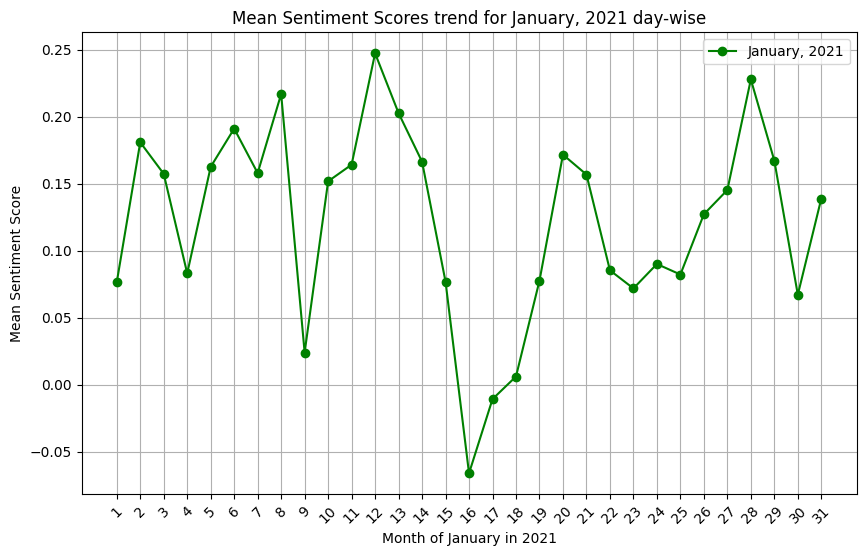

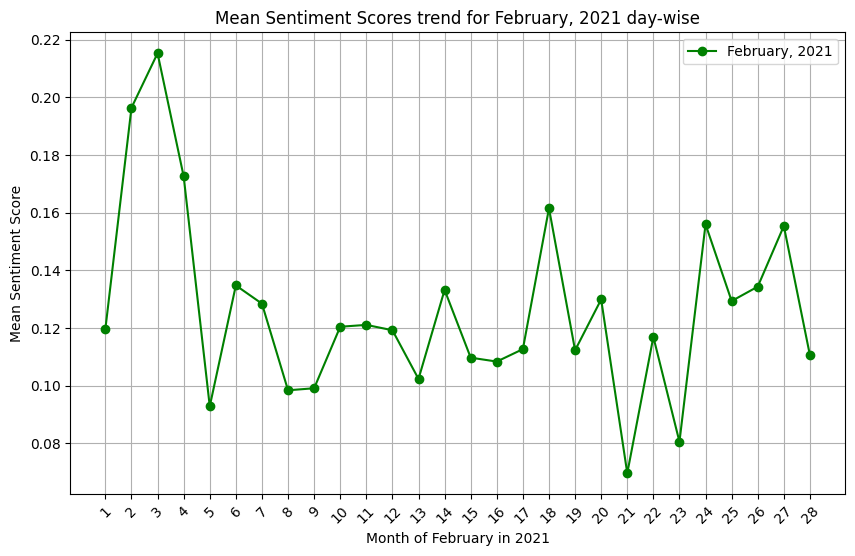

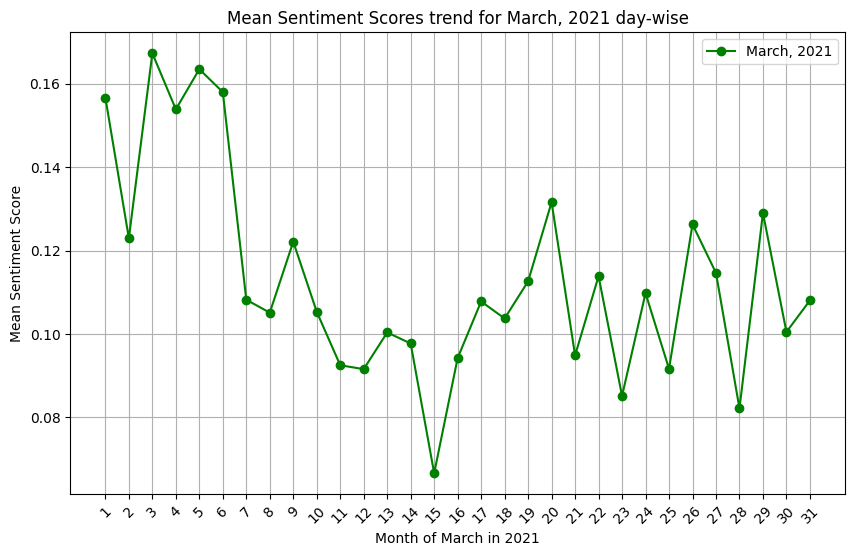

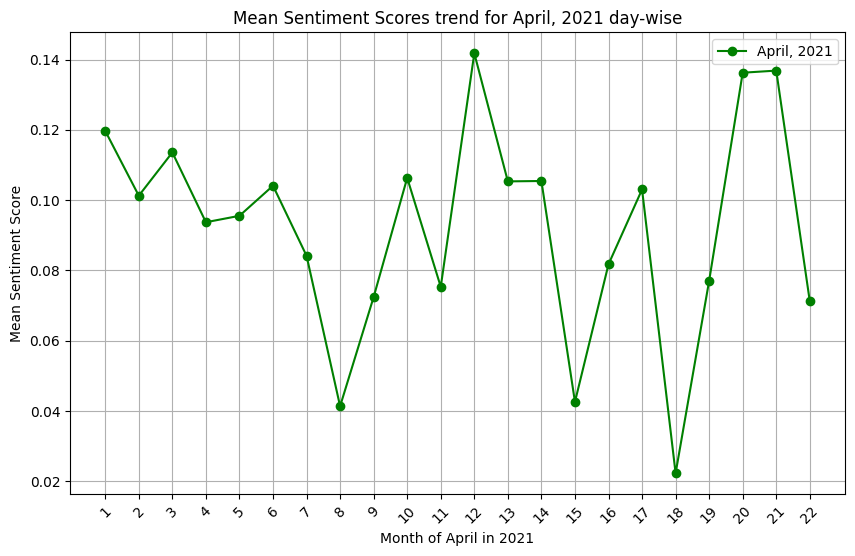

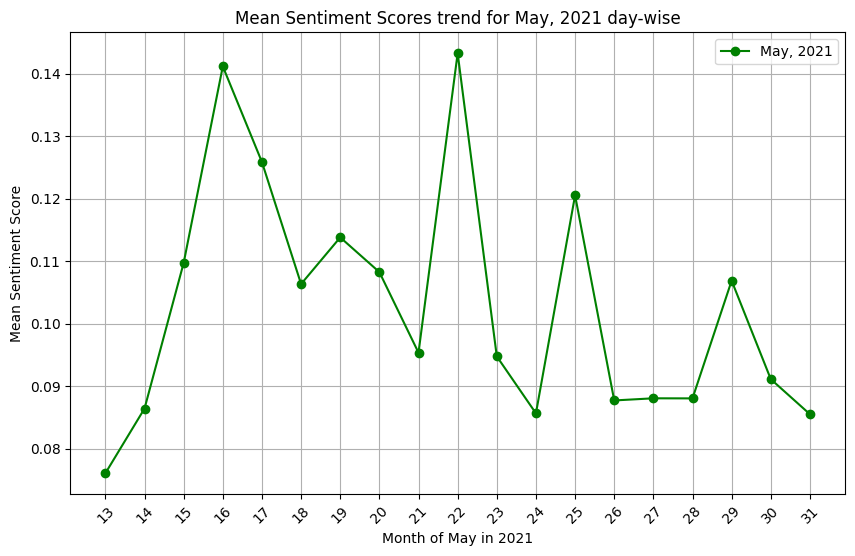

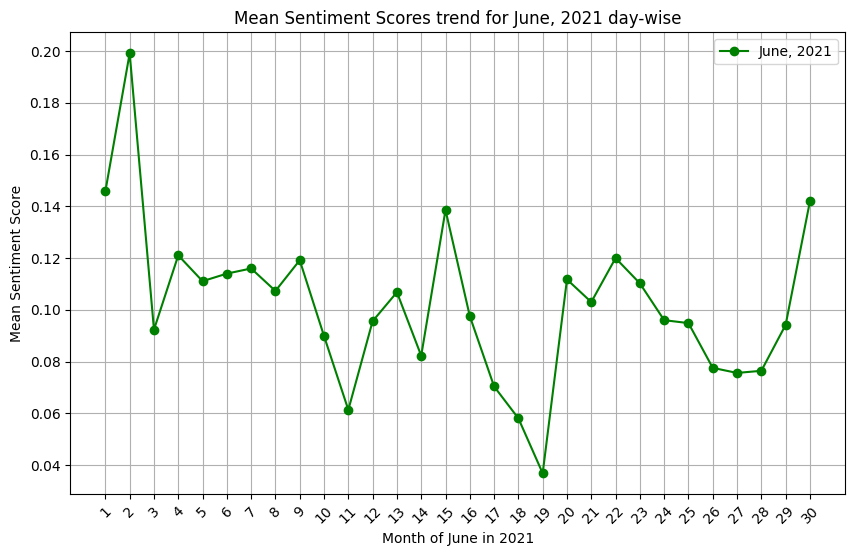

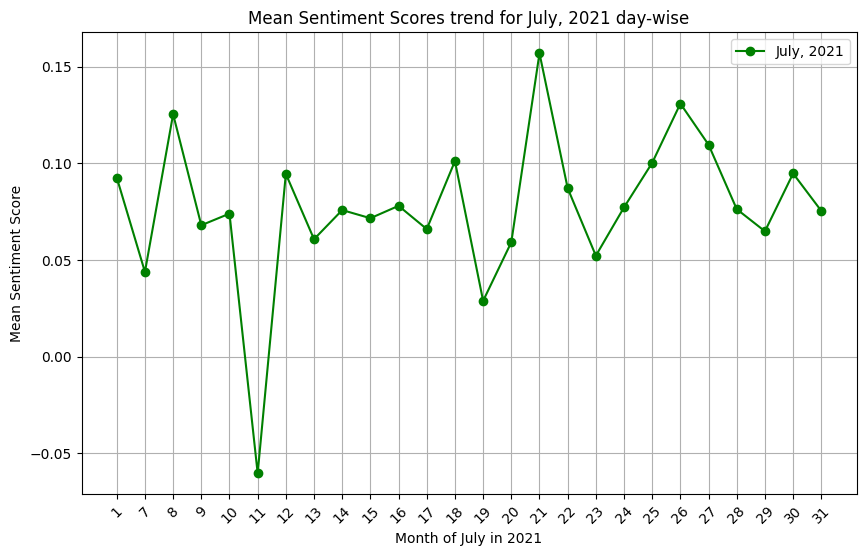

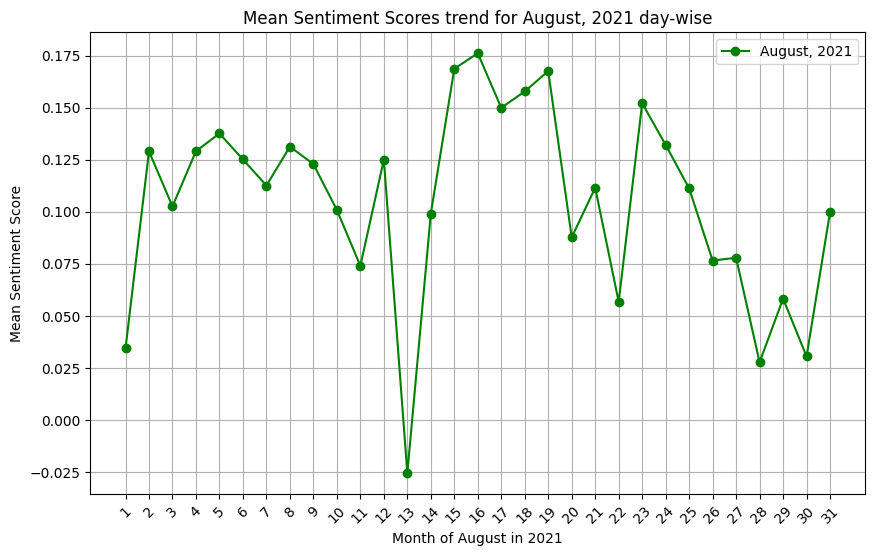

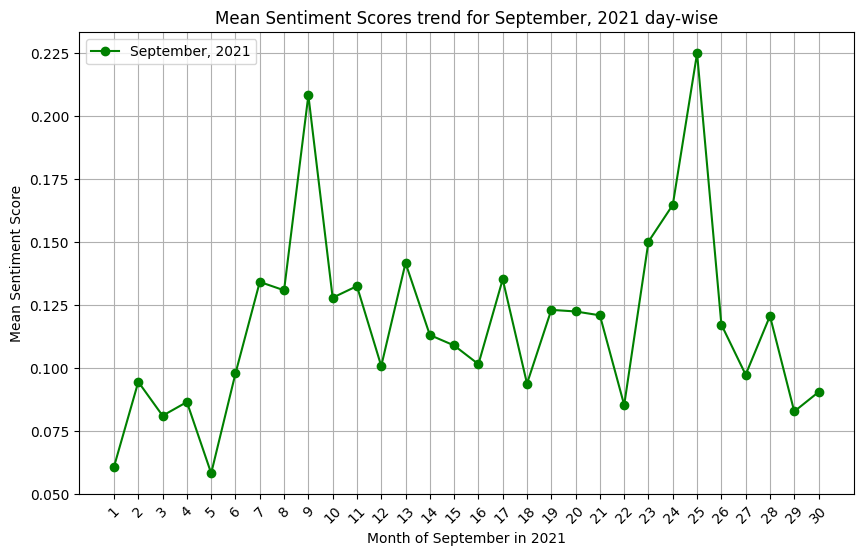

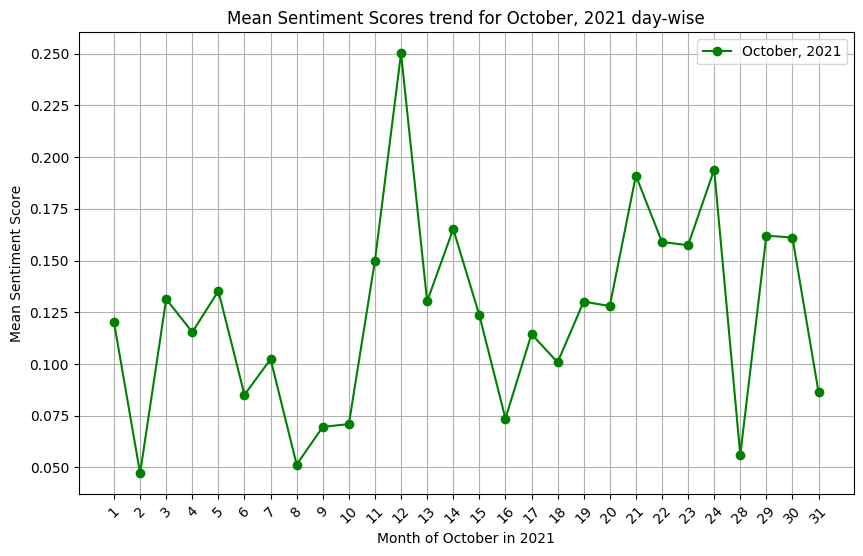

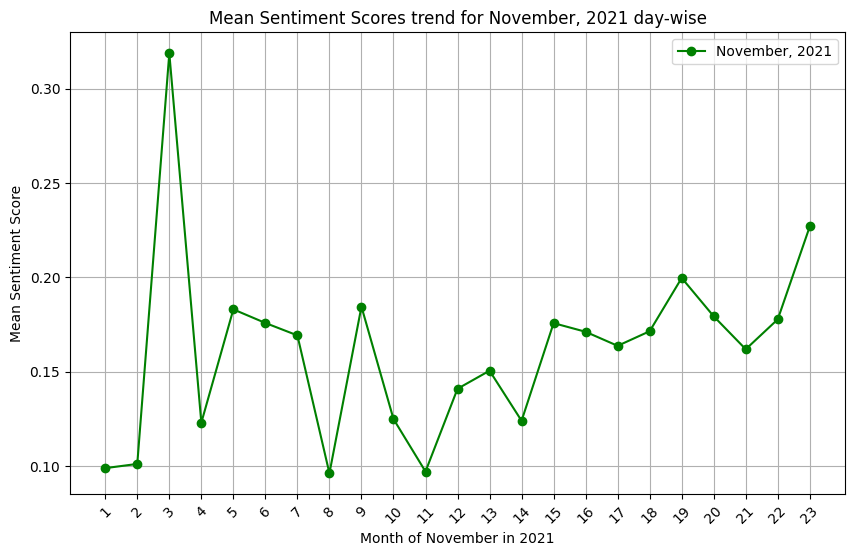

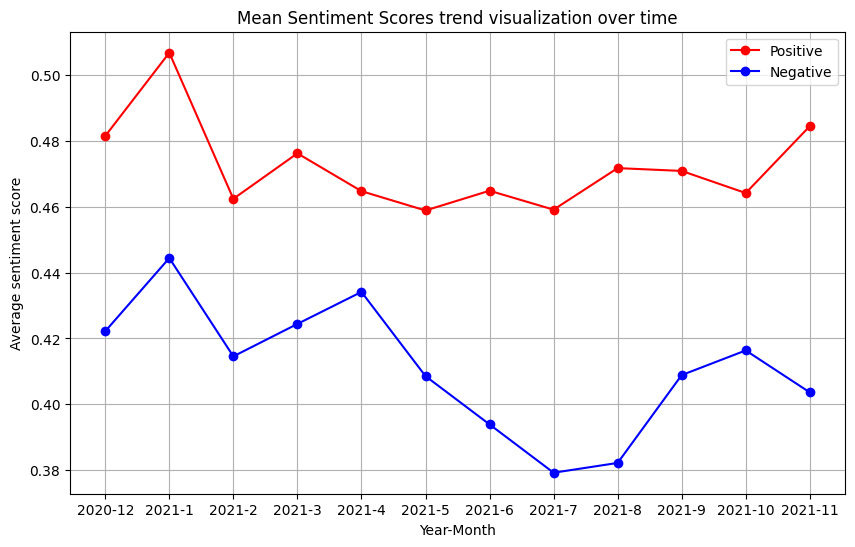

In [39]:
Window=Tk()
Window.title("Sentiment Analysis")
text=Label(Window, text="The dataset must consist of two columns: Timestamp and Tweet.")
text.grid(row=1, column=0, padx=5, pady=5)
filepath=Label(Window, text="Enter the path of the file (Only Excel files): ")
file_path_entry=Entry(Window, width=50)
file_path_entry.grid(row=0, column=0, padx=5, pady=5)

Browse_btn=Button(Window, text="Browse", command=browse_file)
Browse_btn.grid(row=0, column=1, padx=5, pady=5)

sentiment=Button(Window, text="Sentiment Analysis", command=analysis)
sentiment.grid(row=2, column=0, padx=5, pady=5)

visualise_btn = Button(Window, text="Visualize", command=visualise_btn_press)
visualise_btn.grid(row=2, column=1, padx=5, pady=5)

Window.mainloop()